# M2608.001300 Machine Learning <br> Assignment #3-1 support vector machine, linear kernel

Copyright (C) Data Science and Artificial Intelligence Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jeonghee Jo, April 2018

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **student_id** as input argument. <br>
This will produce a zipped file called *[student_id].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; student_id)

## Load dataset

In [259]:
import pickle
import random
import time

from __future__ import print_function
import numpy as np
from numpy import exp, linalg
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [260]:
f = open("train_images.pickle", 'rb')
train_images = pickle.load(f)
f.close()

f2 = open("train_labels.pickle", 'rb')
train_labels = pickle.load(f2)
f2.close()

g = open("test_images.pickle", 'rb')
test_images = pickle.load(g)
g.close()

g2 = open("test_labels.pickle", 'rb')
test_labels = pickle.load(g2)
g2.close()

In [261]:
print("train images shape: ", train_images.shape)
print("train labels shape: ", train_labels.shape)
print("test images shape: ", test_images.shape)
print("test labels shape: ", test_labels.shape)

train images shape:  (10000, 28, 28)
train labels shape:  (10000,)
test images shape:  (5000, 28, 28)
test labels shape:  (5000,)


In [262]:
num_training = train_images.shape[0]
image_size = train_images.shape[1]

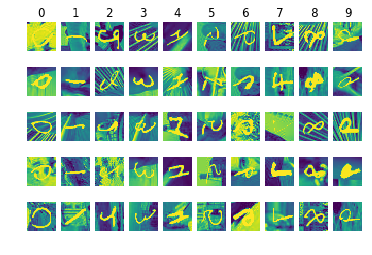

In [263]:
classes = list(range(10))

num_classes = 10
sample_per_class = 5


for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_labels == y)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_per_class, num_classes, plt_idx)
        plt.imshow(train_images[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

## Preprocessing

In [264]:
train_images = np.reshape(train_images, (np.array(train_images).shape[0], -1))
test_images = np.reshape(test_images, (np.array(test_images).shape[0], -1))

print("Training data shape: ", train_images.shape)
print("Test data shape: ", test_images.shape)

Training data shape:  (10000, 784)
Test data shape:  (5000, 784)


In [265]:
#print(train_images[0])
#print((train_images[0]+0.25).astype(int))
train_temp = np.zeros(train_images.shape)
test_temp = np.zeros(test_images.shape)

In [266]:
#ADDED PREPROCESSING STAGE
#threshold function
    
for i in range(train_images.shape[0]):
    train_temp[i] = (train_images[i]+0.027).astype(int)
        
for i in range(test_images.shape[0]):
    test_temp[i] = (test_images[i]+0.027).astype(int)

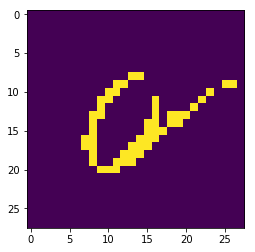

In [267]:
plt.imshow(train_temp[0].reshape((28,28)))

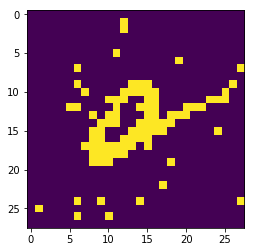

In [268]:

plt.imshow(train_temp[train_images.shape[0]-1].reshape((28,28)))

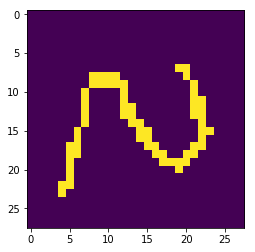

In [269]:
plt.imshow(test_temp[0].reshape((28,28)).astype('uint8'))

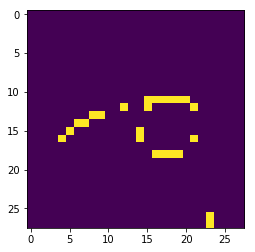

In [270]:
plt.imshow(test_temp[test_images.shape[0]-1].reshape((28,28)))

In [271]:
train_images = train_temp
test_images = test_temp

In [272]:
np.random.seed(0)

[0.0129 0.0123 0.012  0.0106 0.0108 0.0113 0.0125 0.0117 0.0107 0.0098]


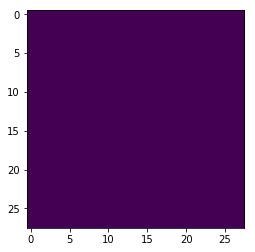

In [273]:
mean_image = np.mean(train_images, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28)).astype('uint8'))
plt.show()

In [274]:
train_images -= mean_image
test_images -= mean_image

In [275]:
train_images = train_images.reshape((-1, image_size * image_size)).astype(np.float32)
test_images = test_images.reshape((-1, image_size * image_size)).astype(np.float32)

print("train_images", train_images.shape)
print("train_labels", train_labels.shape)
print("test_images", test_images.shape)
print("test_labels", test_labels.shape)

train_images (10000, 784)
train_labels (10000,)
test_images (5000, 784)
test_labels (5000,)


In [276]:
train_images = np.reshape(train_images, (train_images.shape[0], -1))
test_images = np.reshape(test_images, (test_images.shape[0], -1))

print('Training data shape: ', train_images.shape)
print('Test data shape: ', test_images.shape)

Training data shape:  (10000, 784)
Test data shape:  (5000, 784)


In [277]:
train_images = np.hstack([train_images, np.ones((train_images.shape[0], 1))])
test_images = np.hstack([test_images, np.ones((test_images.shape[0], 1))])
train_labels_onehot = np.zeros((len(train_labels), 10))
train_labels_onehot[range(len(train_labels)), train_labels] += 1

print("train_images", train_images.shape)
print("train_labels", train_labels.shape)
print("test_images", test_images.shape)
print("test_labels", test_labels.shape)

train_images (10000, 785)
train_labels (10000,)
test_images (5000, 785)
test_labels (5000,)


## **1. function <i>svm_loss_one</i>**

    Structured SVM loss function, naive implemntation (with loops).
    Inputs have dimension D, there are C classes, and we operate on minibatches of N samples.
    
`Inputs:`
- W: A numpy array of shape (D, C) containing weights.
- X: A numpy array of shape (N, D) containing a minibatch of data.
- y: A numpy array of shape (N,) containing labels; y[i] = c means that X[i] has label c, where 0 <= c < C.
- reg: (float) regularization strength
    
`Returns a tuple of`
- loss as single float
- gradient with respect to weights W; an array of same shape as W
    

In [278]:
def svm_loss_one(W, X, y, reg):
    
    dW = np.zeros(W.shape)
    num_classes = W.shape[1]
    num_train = X.shape[0]
    delta = 1.0
    
    loss = 0.0
    
    for i in range(num_train):
        scores = np.matmul(X[i], W)# TO DO
        correct_class_score = scores[y[i]]
        num_incorrect = 0
        
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # delta = 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i]
                dW[:, y[i]] += -X[i] # TO DO
                
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)

    dW /= num_train
    dW += reg * W

    return loss, dW
    

In [279]:
W = np.random.randn(785, 10) * 0.0001

loss, _ = svm_loss_one(W, train_images[:1000], train_labels[:1000], 1e-2)

print("loss: %f" %(loss))

loss: 9.000410


## **2. function <i>svm_loss_all</i>**

Inputs and outputs are the same as <i>svm_loss_one</i>

In [280]:
def svm_loss_all(W, X, y, reg):
    
    dW = np.zeros(W.shape)
    
    num_train = X.shape[0]
    delta = 1.0
    
    loss = 0.0
    
    scores = np.matmul(X, W) # TO DO
    correct_class_score = scores[np.arange(num_train), y]

    margins = np.maximum(0, scores - correct_class_score[:, np.newaxis] + delta)

    margins[np.arange(num_train), y] = 0
    

    # TO DO
    
    loss = np.sum(margins) / num_train
    loss += 0.5 * reg * np.sum(W * W)
    
    #
    #
    #
    
    
    L = np.zeros(margins.shape)
    L[margins > 0] = 1
    incorrect_counts = np.sum(L, axis=1)   
    L[np.arange(num_train), y] = -incorrect_counts
    dW = np.matmul(X.T, L)  
    #
    #
    #
    dW /= num_train
    dW += reg * W
    
    return loss, dW

In [281]:
W = np.random.randn(785, 10) * 0.0001

loss, dW = svm_loss_all(W, train_images[:1000], train_labels[:1000], 1e-2)


'\nloss, dW = svm_loss_one(W, train_images[:1000], train_labels[:1000], 1e-2)\n\nprint("loss: %f" %(loss))\nprint(dW)\n'

In [297]:
class LinearSVM(object):
    
    def __init__(self):
        self.W = None
        self.loss_history = []
        self.num_train = None
        self.dim = None
        self.num_classes = None
    
    def set_weight(self, _W):
        self.W = _W
        
    def loss(self, X_batch, y_batch, reg):
        #loss, grad = svm_loss_one(self.W, X_batch, y_batch, reg)
        loss, grad = svm_loss_all(self.W, X_batch, y_batch, reg)
        self.loss_history.append(loss)
        return loss, grad
    
    def update_weights(self, grad, learning_rate):
        # TO DO
        self.W += -1.0*learning_rate*grad
        
    def train(self, X, y, learning_rate, reg, num_iters, batch_size, verbose=True):
        
        opt_iter = 0
        opt_W = 0
        opt_acc = 0
        
        self.num_train = X.shape[0]
        self.dim = X.shape[1]
        self.num_classes = np.max(y) + 1
        
        if self.W is None:
            self.W = 0.001 * np.random.randn(self.dim, self.num_classes)
            
        for iteration in range(1, num_iters+1):
            X_batch, y_batch = None, None
            
            random_indices = np.random.choice(self.num_train, batch_size)
            X_batch, y_batch = X[random_indices], y[random_indices]
            
            _, grad = self.loss(X_batch, y_batch, reg)
            
            self.update_weights(grad, learning_rate)
            
            if iteration%100 == 0:
                #print("loss %f at iteration %d " %(np.sum(self.loss_history[-100:])/batch_size, int(iteration)))
                test_labels_pred = self.predict(test_images)
                test_acc = np.mean(test_labels_pred == test_labels)
                #print("iteration %d accuracy: %.2f" %(int(iteration), test_acc*100))
                if opt_acc < test_acc*100:
                    opt_iter = int(iteration)
                    opt_W = self.W.copy()
                    opt_acc = test_acc*100
        return opt_iter, opt_W, opt_acc
        
    def predict(self, X):
        
        num_test = X.shape[0]
        #y_pred = np.ones[num_test]
        scores = np.matmul(X, self.W)
        y_pred = np.argmax(scores, axis=1)
        #print(y_pred.shape)
        
        return y_pred

In [304]:
#0.027

l_rates = [5.9e-7, 6e-7, 6.1e-7]
regs = [47500, 50000, 52500]
#l_rates = [1e-5, 1e-6]
#regs = [1000, 5000]
#regs = []

opt_iter = 0
opt_W = 0
opt_acc = 0
opt_lr = 0
opt_r = 0
opt_it = 0

svm = LinearSVM()
for it in range(120):
    print("Iter: ", it)
    for lr in l_rates:
        for r in regs:
            print()
            print("hyperparameters", lr, r)
            it, W, acc = svm.train(train_images, train_labels, learning_rate=1e-5, reg=100000, num_iters=10000, batch_size=500) # TO DO
            
        
            if opt_acc<acc:
                opt_iter = it
                opt_W = W
                opt_acc = acc
                opt_lr = lr
                opt_r = r
                opt_it = it
            
            print(it, 'accuracy', acc, ' opt.accuracy', opt_acc)
            
print()
print("optimal:", "learning rate", opt_lr, "reg", opt_r, "iter", opt_iter, "accuracy", opt_acc)

Iter:  0

hyperparameters 5.9e-07 47500
4100 accuracy 67.58  opt.accuracy 67.58

hyperparameters 5.9e-07 50000
6400 accuracy 68.97999999999999  opt.accuracy 68.97999999999999

hyperparameters 5.9e-07 52500
9300 accuracy 66.84  opt.accuracy 68.97999999999999

hyperparameters 6e-07 47500
5100 accuracy 66.28  opt.accuracy 68.97999999999999

hyperparameters 6e-07 50000
4400 accuracy 67.97999999999999  opt.accuracy 68.97999999999999

hyperparameters 6e-07 52500
3100 accuracy 67.96  opt.accuracy 68.97999999999999

hyperparameters 6.1e-07 47500
7700 accuracy 67.80000000000001  opt.accuracy 68.97999999999999

hyperparameters 6.1e-07 50000
6100 accuracy 67.24  opt.accuracy 68.97999999999999

hyperparameters 6.1e-07 52500
3600 accuracy 67.30000000000001  opt.accuracy 68.97999999999999
Iter:  1

hyperparameters 5.9e-07 47500
5000 accuracy 67.58  opt.accuracy 68.97999999999999

hyperparameters 5.9e-07 50000
5900 accuracy 67.92  opt.accuracy 68.97999999999999

hyperparameters 5.9e-07 52500
9800 acc

1500 accuracy 69.14  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
5200 accuracy 66.84  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
3800 accuracy 66.8  opt.accuracy 70.38
Iter:  11

hyperparameters 5.9e-07 47500
400 accuracy 67.94  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
9400 accuracy 66.94  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
5000 accuracy 67.52  opt.accuracy 70.38

hyperparameters 6e-07 47500
4800 accuracy 66.67999999999999  opt.accuracy 70.38

hyperparameters 6e-07 50000
4900 accuracy 68.17999999999999  opt.accuracy 70.38

hyperparameters 6e-07 52500
1400 accuracy 68.38  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
100 accuracy 66.58  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
9500 accuracy 67.2  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
7400 accuracy 67.97999999999999  opt.accuracy 70.38
Iter:  12

hyperparameters 5.9e-07 47500
6500 accuracy 66.67999999999999  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
7400 accuracy 67.14

2000 accuracy 67.38  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
1600 accuracy 66.52  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
1000 accuracy 69.19999999999999  opt.accuracy 70.38

hyperparameters 6e-07 47500
1600 accuracy 68.08  opt.accuracy 70.38

hyperparameters 6e-07 50000
7800 accuracy 68.16  opt.accuracy 70.38

hyperparameters 6e-07 52500
9500 accuracy 67.44  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
5600 accuracy 68.42  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
5700 accuracy 67.5  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
300 accuracy 67.32000000000001  opt.accuracy 70.38
Iter:  24

hyperparameters 5.9e-07 47500
2600 accuracy 68.16  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
4600 accuracy 66.96  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
1000 accuracy 67.17999999999999  opt.accuracy 70.38

hyperparameters 6e-07 47500
1200 accuracy 68.02  opt.accuracy 70.38

hyperparameters 6e-07 50000
1300 accuracy 67.67999999999999  opt.accura

7400 accuracy 66.08000000000001  opt.accuracy 70.38

hyperparameters 6e-07 50000
7800 accuracy 68.22  opt.accuracy 70.38

hyperparameters 6e-07 52500
7800 accuracy 68.12  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
4300 accuracy 67.36  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
2800 accuracy 66.9  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
7700 accuracy 66.9  opt.accuracy 70.38
Iter:  36

hyperparameters 5.9e-07 47500
1300 accuracy 68.08  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
500 accuracy 67.52  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
7700 accuracy 67.66  opt.accuracy 70.38

hyperparameters 6e-07 47500
3600 accuracy 67.78  opt.accuracy 70.38

hyperparameters 6e-07 50000
6600 accuracy 67.7  opt.accuracy 70.38

hyperparameters 6e-07 52500
6800 accuracy 66.88  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
2500 accuracy 67.67999999999999  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
5700 accuracy 66.7  opt.accuracy 70.38

hyperparameters 6

5000 accuracy 67.38  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
5900 accuracy 68.0  opt.accuracy 70.38
Iter:  48

hyperparameters 5.9e-07 47500
1400 accuracy 68.46  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
7600 accuracy 68.02  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
900 accuracy 68.16  opt.accuracy 70.38

hyperparameters 6e-07 47500
500 accuracy 67.06  opt.accuracy 70.38

hyperparameters 6e-07 50000
6100 accuracy 68.7  opt.accuracy 70.38

hyperparameters 6e-07 52500
7200 accuracy 70.02000000000001  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
1200 accuracy 68.14  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
8800 accuracy 67.2  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
3100 accuracy 68.14  opt.accuracy 70.38
Iter:  49

hyperparameters 5.9e-07 47500
6000 accuracy 67.36  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
6800 accuracy 68.76  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
9700 accuracy 67.88  opt.accuracy 70.38

hyperparameters

1900 accuracy 67.75999999999999  opt.accuracy 70.38

hyperparameters 6e-07 47500
300 accuracy 67.34  opt.accuracy 70.38

hyperparameters 6e-07 50000
700 accuracy 66.58  opt.accuracy 70.38

hyperparameters 6e-07 52500
2200 accuracy 67.06  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
2000 accuracy 68.7  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
3900 accuracy 66.2  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
2700 accuracy 67.16  opt.accuracy 70.38
Iter:  61

hyperparameters 5.9e-07 47500
2400 accuracy 68.2  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
4800 accuracy 68.7  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
5000 accuracy 66.75999999999999  opt.accuracy 70.38

hyperparameters 6e-07 47500
8500 accuracy 67.64  opt.accuracy 70.38

hyperparameters 6e-07 50000
9700 accuracy 66.94  opt.accuracy 70.38

hyperparameters 6e-07 52500
7900 accuracy 66.94  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
7100 accuracy 69.06  opt.accuracy 70.38

hyperparameters 6.1e

2900 accuracy 67.66  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
5300 accuracy 67.64  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
6800 accuracy 68.74  opt.accuracy 70.38
Iter:  73

hyperparameters 5.9e-07 47500
7800 accuracy 67.2  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
1600 accuracy 68.64  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
3100 accuracy 67.75999999999999  opt.accuracy 70.38

hyperparameters 6e-07 47500
2200 accuracy 66.8  opt.accuracy 70.38

hyperparameters 6e-07 50000
5900 accuracy 67.64  opt.accuracy 70.38

hyperparameters 6e-07 52500
8500 accuracy 69.69999999999999  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
7500 accuracy 68.4  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
7700 accuracy 67.67999999999999  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
4800 accuracy 67.82000000000001  opt.accuracy 70.38
Iter:  74

hyperparameters 5.9e-07 47500
4400 accuracy 68.04  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
9600 accuracy 67.2

9900 accuracy 68.12  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
9800 accuracy 66.92  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
1100 accuracy 66.96  opt.accuracy 70.38

hyperparameters 6e-07 47500
500 accuracy 67.4  opt.accuracy 70.38

hyperparameters 6e-07 50000
3100 accuracy 67.75999999999999  opt.accuracy 70.38

hyperparameters 6e-07 52500
4800 accuracy 67.34  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
4200 accuracy 67.36  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
9400 accuracy 67.78  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
7000 accuracy 69.12  opt.accuracy 70.38
Iter:  86

hyperparameters 5.9e-07 47500
1000 accuracy 67.4  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
9100 accuracy 68.0  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
7900 accuracy 67.34  opt.accuracy 70.38

hyperparameters 6e-07 47500
5400 accuracy 66.3  opt.accuracy 70.38

hyperparameters 6e-07 50000
1000 accuracy 68.42  opt.accuracy 70.38

hyperparameters 6e-07 52500
5

9800 accuracy 68.97999999999999  opt.accuracy 70.38

hyperparameters 6e-07 52500
9400 accuracy 67.24  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
6300 accuracy 67.17999999999999  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
7200 accuracy 67.66  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
5300 accuracy 69.04  opt.accuracy 70.38
Iter:  98

hyperparameters 5.9e-07 47500
4100 accuracy 67.30000000000001  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
6100 accuracy 67.84  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
4000 accuracy 67.04  opt.accuracy 70.38

hyperparameters 6e-07 47500
8900 accuracy 65.62  opt.accuracy 70.38

hyperparameters 6e-07 50000
9400 accuracy 68.24  opt.accuracy 70.38

hyperparameters 6e-07 52500
6700 accuracy 68.84  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
3600 accuracy 68.02  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
600 accuracy 68.30000000000001  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
1400 accuracy 66.92  opt.acc

3500 accuracy 68.96  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
6900 accuracy 67.02  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
7900 accuracy 68.42  opt.accuracy 70.38
Iter:  110

hyperparameters 5.9e-07 47500
400 accuracy 67.14  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
1900 accuracy 67.44  opt.accuracy 70.38

hyperparameters 5.9e-07 52500
3200 accuracy 68.14  opt.accuracy 70.38

hyperparameters 6e-07 47500
9800 accuracy 67.97999999999999  opt.accuracy 70.38

hyperparameters 6e-07 50000
3900 accuracy 66.47999999999999  opt.accuracy 70.38

hyperparameters 6e-07 52500
300 accuracy 67.22  opt.accuracy 70.38

hyperparameters 6.1e-07 47500
7100 accuracy 68.47999999999999  opt.accuracy 70.38

hyperparameters 6.1e-07 50000
900 accuracy 67.16  opt.accuracy 70.38

hyperparameters 6.1e-07 52500
8400 accuracy 66.84  opt.accuracy 70.38
Iter:  111

hyperparameters 5.9e-07 47500
7600 accuracy 67.04  opt.accuracy 70.38

hyperparameters 5.9e-07 50000
4400 accuracy 67.42  opt.acc

In [305]:
svm.set_weight(opt_W)

In [306]:
test_labels_pred = svm.predict(test_images)

In [307]:
test_acc = np.mean(test_labels_pred == test_labels)

In [308]:
print("test accuracy: %.2f" %(test_acc*100))

test accuracy: 70.38
